In [1]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.transform import Rotation
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(41)
np.random.seed(41)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

Self-interaction of all 3 given shapes can be learnt by one 3-layer NN. Accuracy is really good. Please note it's just 3 shapes of 3 types, we didn't vary axis sizes for any a,b,c values for any particular shape.

This is not something we tried for two-body case (single NN for multiple shapes, or even similar shape but different a,b,c).

In [2]:
def compute_rotvec_batch(rot_partial_flat):
    N = rot_partial_flat.shape[0]
    R_partial = rot_partial_flat.reshape(N, 3, 2)
    R3 = np.cross(R_partial[:, :, 0], R_partial[:, :, 1])
    R_full = np.concatenate((R_partial, R3[:, :, np.newaxis]), axis=2)  # shape (N,3,3)
    rotvecs = Rotation.from_matrix(R_full).as_rotvec()  # shape (N,3)
    return rotvecs

def rotate_forces_torques_to_body(forces_lab, torques_lab, rotvec):
    """
    Rotate forces & torques from lab frame to the body frame (which we'll
    assume is aligned with the spheroid's major axis = z-axis in the body frame).
    
    forces_lab, torques_lab, rotvec all have shape (N,3).
    """
    # Create a batch of Rotation objects from each rotvec
    rot = Rotation.from_rotvec(rotvec)   # shape: (N,) - a stack of N rotations
    
    # 'inverse=True' rotates vectors *into* the body frame
    forces_body = rot.apply(forces_lab, inverse=True)
    torques_body = rot.apply(torques_lab, inverse=True)
    
    return forces_body, torques_body

In [3]:

xs,ys = [],[]

xs.append(np.load("../data/X_self_oblateSpheroid_23:07_4.npy"))
ys.append(np.load("../data/Y_self_oblateSpheroid_23:07_4.npy"))

xs.append(np.load("../data/X_self_prolateSpheroid_23:09_4.npy"))
ys.append(np.load("../data/Y_self_prolateSpheroid_23:09_4.npy"))


xs.append(np.load("../data/X_self_sphere_22:42_4.npy"))
ys.append(np.load("../data/Y_self_sphere_22:42_4.npy"))

X = np.concatenate(xs, axis=0)
Y = np.concatenate(ys, axis=0)
orient = compute_rotvec_batch(X[:,3:9]) # convert rotation matrix to vector

# we'll project force and torque to "body frame" (major axis z-axis algined)
# This way, we can ignore particle's orientation for mobility calculation
# We will have to project velocity back to "lab frame" later- after M @ F.
f,t = rotate_forces_torques_to_body(X[:, 9:12], X[:, 12:15], orient)
Y[:, :3], Y[:, 3:] = rotate_forces_torques_to_body(Y[:, :3], Y[:, 3:], orient)
X[:, 9:12], X[:, 12:15] = f, t


# remove abc
# x = x[:, 3:]

X = torch.Tensor(X).to(device)
Y = torch.Tensor(Y).to(device)
#orient = torch.Tensor(orient).to(device) 

X.shape, Y.shape

(torch.Size([30000, 15]), torch.Size([30000, 6]))

In [4]:
xs[-1].shape, xs[-2].shape

((10000, 15), (10000, 15))

In [5]:
def shuffle(*arrays):
    # Ensure that all arrays have the same first dimension.
    n = arrays[0].shape[0]
    idx = torch.randperm(n)
    return tuple(arr[idx] for arr in arrays)

X, Y = shuffle(X,Y)

split_frac = .8
split_point = int(split_frac * X.size(0))

X_train, X_val = X[:split_point], X[split_point:]
Y_train, Y_val = Y[:split_point], Y[split_point:]
#orient_train, orient_val = orient[:split_point], orient[split_point:]

X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

(torch.Size([24000, 15]),
 torch.Size([6000, 15]),
 torch.Size([24000, 6]),
 torch.Size([6000, 6]))

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfNetwork(nn.Module):
    """
    Neural network that predicts the 4 key self-mobility scalars for an
    axisymmetric particle in Stokes flow:
       mu_T_parallel, mu_T_perp, mu_R_parallel, mu_R_perp
    """
    def __init__(self, input_dim):
        super(SelfNetwork, self).__init__()
        
        # Example architecture. You can tweak layer sizes or add more layers as needed.
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
            #nn.Tanh()
        )

    def forward(self, x):
        """
        x includes whatever parameters you need to predict the mobility
        scalars (e.g. aspect ratio, orientation in some parameterization, etc.)
        Returns the 4 scalars: [mu_T_para, mu_T_perp, mu_R_para, mu_R_perp].
        """
        return self.layers(x)

    def predict_velocity(self, x, force):
        """
        force:  tensor of shape (batch_size, 6) -> [Fx, Fy, Fz, Tx, Ty, Tz]
        
        Steps:
        1) Forward pass to get the 4 mobility scalars.
        2) Construct the diagonal 3x3 blocks M^{TT}, M^{RR} because
           the particle's major axis is z-axis.
        3) Multiply by force => velocity [Ux, Uy, Uz, Ox, Oy, Oz].
        """
        # 1) Get the mobility scalars
        mus = self.forward(x)  # shape (batch_size, 4)
        mu_T_para = mus[:, 0]  # (batch_size,)
        mu_T_perp = mus[:, 1]
        mu_R_para = mus[:, 2]
        mu_R_perp = mus[:, 3]

        F_3    = force[:, 0:3]  # (batch_size, 3)
        tau_3  = force[:, 3:6]  # (batch_size, 3)

        # 2) For each sample, build M^{TT} and M^{RR} as diag:
        #    M^{TT} = diag(mu_T_perp, mu_T_perp, mu_T_para)
        #    M^{RR} = diag(mu_R_perp, mu_R_perp, mu_R_para)
        # We'll do it in a batched way:
        
        # expand dims for broadcasting
        mu_T_para_ = mu_T_para.view(-1, 1)  # (batch_size,1)
        mu_T_perp_ = mu_T_perp.view(-1, 1)
        mu_R_para_ = mu_R_para.view(-1, 1)
        mu_R_perp_ = mu_R_perp.view(-1, 1)

        # velocity in the z-axis aligned frame:
        #   Ux = mu_T_perp * Fx
        #   Uy = mu_T_perp * Fy
        #   Uz = mu_T_para * Fz
        Ux = mu_T_perp_ * F_3[:,0:1]
        Uy = mu_T_perp_ * F_3[:,1:2]
        Uz = mu_T_para_ * F_3[:,2:3]

        # angular velocity:
        #   Ox = mu_R_perp * Tx
        #   Oy = mu_R_perp * Ty
        #   Oz = mu_R_para * Tz
        Ox = mu_R_perp_ * tau_3[:,0:1]
        Oy = mu_R_perp_ * tau_3[:,1:2]
        Oz = mu_R_para_ * tau_3[:,2:3]

        U = torch.cat([Ux, Uy, Uz], dim=1)       # (batch_size, 3)
        Omega = torch.cat([Ox, Oy, Oz], dim=1)   # (batch_size, 3)

        # Combine
        velocity = torch.cat([U, Omega], dim=1)  # (batch_size, 6)
        return velocity

In [7]:
# class SelfNetwork(nn.Module):
#     def __init__(self, input_dim):
#         super(SelfNetwork, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 128),
#             nn.Relu(),
#             nn.Linear(128, 6),
#         )

#     def forward(self, r):
#         return self.layers(r)


input_dim = 9 # a,b,c and orientation
batch_size = 256
epochs = 200
model = SelfNetwork(input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.50)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


criterion = nn.L1Loss()
n_iter = X_train.shape[0]//batch_size
n_iter, n_iter*batch_size, len(X_train)

(93, 23808, 24000)

In [8]:
losses = []
for epoch in range(epochs):
    model.train()
    avg = 0

    X_train, Y_train = shuffle(X_train, Y_train) #dont forget orient if it comes back
    for it in range(n_iter):
        optimizer.zero_grad()
        
        indices = torch.arange(it*batch_size, (it+1)*batch_size, dtype=torch.int).cuda()
        X_batch = X_train[indices, :9]
        F_batch = X_train[indices, 9:]
        #orient_batch = orient_train[indices]
        Y_batch = Y_train[indices]
        
        batch_output = model.predict_velocity(X_batch, F_batch)

        # Compute loss
        loss = criterion(batch_output, Y_batch)
        
        loss.backward()
        avg += loss.item()
        optimizer.step()
        

    scheduler.step()
    if epoch%5==0:
        print(f'Epoch {epoch}, Loss: {avg/n_iter}')
        losses.append(avg/n_iter)

torch.save(model.state_dict(), "self_interaction.wt")

Epoch 0, Loss: 0.061760029304892786
Epoch 5, Loss: 0.00796633488398486
Epoch 10, Loss: 0.006938208863439579
Epoch 15, Loss: 0.006087146133625059
Epoch 20, Loss: 0.005376583001556336
Epoch 25, Loss: 0.004553353653029008
Epoch 30, Loss: 0.003102881699970733
Epoch 35, Loss: 0.005585945882303741
Epoch 40, Loss: 0.0031595101933025063
Epoch 45, Loss: 0.0031028128184017634
Epoch 50, Loss: 0.0014909476671437984
Epoch 55, Loss: 0.0013122392116710344
Epoch 60, Loss: 0.0011623470483207575
Epoch 65, Loss: 0.0011391607520010282
Epoch 70, Loss: 0.0015607935818342832
Epoch 75, Loss: 0.0014575047228204947
Epoch 80, Loss: 0.0012015142448006137
Epoch 85, Loss: 0.001588376902384303
Epoch 90, Loss: 0.0016268962450946371
Epoch 95, Loss: 0.00114933452919446
Epoch 100, Loss: 0.00040774511925059984
Epoch 105, Loss: 0.0006182776730863117
Epoch 110, Loss: 0.0006774871344728175
Epoch 115, Loss: 0.0008678499356372863
Epoch 120, Loss: 0.0008125653235687404
Epoch 125, Loss: 0.0005497661928060434
Epoch 130, Loss: 0.

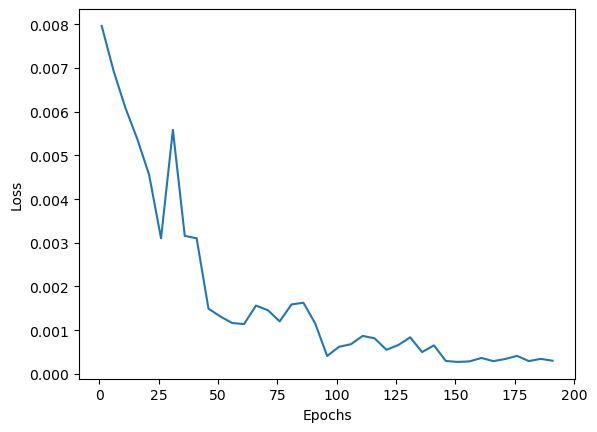

In [14]:
import matplotlib.pyplot as plt
los = losses[1:] # first one is usually too big, messes up the plot
plt.plot(np.arange(len(los))*5+1, los);
plt.ylabel("Loss")
plt.xlabel("Epochs");

In [15]:
model = SelfNetwork(input_dim).to(device)
model.load_state_dict(torch.load("self_interaction.wt", weights_only=True))
model.eval()

with torch.no_grad():
    val_output = model.predict_velocity(X_val[:,:9], X_val[:, 9:])

In [16]:
criterion = nn.MSELoss(reduction='none') 
err = criterion(val_output, Y_val)

rmse = torch.sqrt(err.mean(axis=0))

print("Root Mean Squared error for each of 6 output variables:\n", rmse)
print("Actual Magnitude:\n ", torch.abs(Y_val).mean(axis=0))
print("RMSE:", err.mean()**.5, err.mean())

Root Mean Squared error for each of 6 output variables:
 tensor([5.5591e-04, 5.6229e-04, 2.7823e-04, 8.5612e-05, 8.5486e-05, 6.4610e-04],
       device='cuda:0')
Actual Magnitude:
  tensor([0.3605, 0.3674, 0.3829, 0.0679, 0.0688, 0.0800], device='cuda:0')
RMSE: tensor(0.0004, device='cuda:0') tensor(1.8912e-07, device='cuda:0')


In [23]:
#### Median Relative Absolute Error
def mean_abs_err(val_output, val_velocity_tensor, npp=False):
    # 6D vector: median % error for each vel component
    valid_mask = torch.abs(val_velocity_tensor) > 1e-6
    
    filtered_y_tensor = torch.where(valid_mask, val_velocity_tensor, torch.tensor(float('nan')))
    relative_error = torch.abs((val_output - filtered_y_tensor) / filtered_y_tensor)
    
    a = torch.nanmean(relative_error, dim=0)
    return a*100

mean_abs_err(val_output, Y_val)

tensor([0.1398, 0.1409, 0.0635, 0.1749, 0.1367, 1.1977], device='cuda:0')

In [18]:
frac = rmse/torch.abs(Y_val).mean(axis=0)
frac*100

tensor([0.1542, 0.1531, 0.0727, 0.1261, 0.1243, 0.8075], device='cuda:0')

In [19]:
ii = 124
Y_val[ii], val_output[ii], X_val[ii,:3]

(tensor([-0.4445, -0.1694, -0.4057, -0.0399,  0.0119,  0.0297], device='cuda:0'),
 tensor([-0.4452, -0.1697, -0.4058, -0.0399,  0.0119,  0.0295], device='cuda:0'),
 tensor([1., 1., 3.], device='cuda:0'))

## Error depending on shape

In [27]:
sphere_idx = torch.abs(X_val[:,:3].sum(axis=1)-3.0)<.001
sphere_idx.sum()

tensor(1991, device='cuda:0')

In [28]:
mean_abs_err(val_output[sphere_idx], Y_val[sphere_idx])

tensor([0.0614, 0.0614, 0.0195, 0.0585, 0.0552, 0.3752], device='cuda:0')

In [35]:
prolate = X_val[:,2]==3.0
prolate.sum()

tensor(1990, device='cuda:0')

In [39]:
mean_abs_err(val_output[prolate], Y_val[prolate])

tensor([0.1698, 0.1718, 0.0434, 0.2286, 0.1207, 0.6572], device='cuda:0')

In [37]:
oblate = X_val[:,1]==2.0
oblate.sum()

tensor(2019, device='cuda:0')

In [40]:
mean_abs_err(val_output[oblate], Y_val[oblate])

tensor([0.1875, 0.1888, 0.1267, 0.2369, 0.2329, 2.5416], device='cuda:0')

In [38]:
sphere_idx.sum()+oblate.sum()+prolate.sum()

tensor(6000, device='cuda:0')